In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from phik import phik_matrix
import optuna
from typing import Optional, Union, List
from scipy.stats import kstest
from scipy.stats import zscore
from scipy.stats import ks_2samp, chi2_contingency, chisquare
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from optuna.samplers import RandomSampler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc

In [2]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)
pd.set_option('display.max_columns', None)

DATA_PATH = ''
RANDOM_STATE = 42

In [3]:
local_df_train_path = os.path.join(DATA_PATH, 'shift_ml_2025_train.csv')
local_df_test_path = os.path.join(DATA_PATH, 'shift_ml_2025_test.csv')
local_submission_path = os.path.join(DATA_PATH, 'submission.csv')

In [4]:
df_train = pd.read_csv(local_df_train_path)
df_test = pd.read_csv(local_df_test_path)
submission = pd.read_csv(local_submission_path)

In [5]:
for i,z in zip([df_train,df_test,submission],['df_train','df_test','submission']):
    print(z)
    print()
    print(i.shape)
    print()
    display(i.info())
    display(i.head())
    print(f'–ü–†–û–ü–£–°–ö–û–í –í {z}: {i.isna().sum().sum()}')
    print(f'–Ø–í–ù–´–• –î–£–ë–õ–ò–ö–ê–¢–û–í –í {z}: {i.duplicated().sum()}')
    print('-------------------------------------------------------------------------------------------------------------')
    print()
    print()

df_train

(1210779, 109)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to —Ç–∏–ø_–ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è_–∫—Ä–µ–¥–∏—Ç–∞
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


None

id  —Å—É–º–º–∞_–∑–∞–π–º–∞ —Å—Ä–æ–∫_–∑–∞–π–º–∞  –ø—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è_—Å—Ç–∞–≤–∫–∞  –∞–Ω–Ω—É–∏—Ç–µ—Ç —Ä–µ–π—Ç–∏–Ω–≥  \
0  68355089    1235000.0     3 –≥–æ–¥–∞              11.99   41014.0       –í   
1  68341763    1000000.0      5 –ª–µ—Ç              10.78   21633.0       –ë   
2  68426831     597500.0     3 –≥–æ–¥–∞              13.44   20259.0       –í   
3  68476668    1000000.0     3 –≥–æ–¥–∞               9.17   31879.0       –ë   
4  67275481    1000000.0     3 –≥–æ–¥–∞               8.49   31563.0       –ë   

  –¥–æ–ø—Ä–µ–π—Ç–∏–Ω–≥                           –ø—Ä–æ—Ñ–µ—Å—Å–∏—è_–∑–∞–µ–º—â–∏–∫–∞     —Å—Ç–∞–∂  \
0         –í1                                      –∏–Ω–∂–µ–Ω–µ—Ä  10+ –ª–µ—Ç   
1         –ë4                           –≤–æ–¥–∏—Ç–µ–ª—å –≥—Ä—É–∑–æ–≤–∏–∫–∞  10+ –ª–µ—Ç   
2         –í3                          –≤–µ—Ç–µ—Ä–∏–Ω–∞—Ä–Ω—ã–π —Ç–µ—Ö–Ω–∏–∫   4 –≥–æ–¥–∞   
3         –ë2  –≤–∏—Ü–µ-–ø—Ä–µ–∑–∏–¥–µ–Ω—Ç –æ–ø–µ—Ä–∞—Ü–∏–π –ø–æ –Ω–∞–±–æ—Ä—É –ø–µ—Ä—Å–æ–Ω–∞–ª–∞  10+ –ª–µ—Ç   
4         –ë1                           –¥–æ—Ä–æ–∂–Ω–æ–º—É –≤–æ–¥–∏—Ç–µ–ª—é  10+ –ª–µ—Ç   

  –≤–ª–∞–¥–µ–Ω–∏–µ_–∂–∏–ª—å–µ–º  –≥–æ–¥–æ–≤–æ–π_–¥–æ—Ö–æ–¥  –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω_–ª–∏_–¥–æ—Ö–æ–¥  –∏—Ç–æ–≥–æ–≤—ã–π_—Å—Ç–∞—Ç—É—Å_–∑–∞–π–º–∞  \
0         –ò–ü–û–¢–ï–ö–ê      1300000.0        –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω                      0   
1         –ò–ü–û–¢–ï–ö–ê      1260000.0        –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω                      0   
2          –ê–†–ï–ù–î–ê       680000.0  –ü–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω –∏—Å—Ç–æ—á–Ω–∏–∫                      0   
3         –ò–ü–û–¢–ï–ö–ê      3600000.0        –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω                      0   
4         –ò–ü–û–¢–ï–ö–ê      1700000.0        –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω                      0   

   —Ä–µ–π—Ç–∏–Ω–≥_OCR –ø–ª–∞—Ç–µ–∂–Ω—ã–π_–≥—Ä–∞—Ñ–∏–∫  –∫–æ—ç—Ñ—Ñ_–∞–∫—Ü–∏–æ–Ω–Ω—ã—Ö_–∑–∞—á–∏—Å–ª–µ–Ω–∏–π_–≤_–æ—Å—Ç–∞—Ç–∫–µ  \
0            4                n                              0.899168   
1            2                n                              0.489891   
2            3                n                              0.938662   
3            1                n                              0.868177   
4            4                n                              0.249254   

                   —Ü–µ–ª—å_–∑–∞–π–º–∞  –∫–æ–ª_–≤–æ_—Å—É–±—Å–∏–¥–∏–π_–∑–∞_–≥–æ–¥  –∏–Ω–¥–µ–∫—Å_–ø—Ä–æ–∂–∏–≤–∞–Ω–∏—è  \
0               –º–µ–ª–∫–∏–π_–±–∏–∑–Ω–µ—Å                       0              577.0   
1  —É–ª—É—á—à–µ–Ω–∏–µ_–∂–∏–ª–∏—â–Ω—ã—Ö_—É—Å–ª–æ–≤–∏–π                       0              605.0   
2          –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è_–¥–æ–ª–≥–∞                       0              300.0   
3          –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è_–¥–æ–ª–≥–∞                       0              550.0   
4             –∫—Ä—É–ø–Ω–∞—è_–ø–æ–∫—É–ø–∫–∞                       0              293.0   

                 —Ä–µ–≥–∏–æ–Ω    –ø–¥–Ω –ø–æ—Å_—Å—Ç–æ–ø_—Ñ–∞–∫—Ç–æ—Ä —é—Ä–∏–¥–∏—á–µ—Å–∫–∏–π_—Å—Ç–∞—Ç—É—Å  \
0  –ù–æ–≤–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  16.06             –ù–µ—Ç                –ù–µ—Ç   
1  –†–µ—Å–ø—É–±–ª–∏–∫–∞ –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  10.78             –ù–µ—Ç                –ù–µ—Ç   
2       –†–µ—Å–ø—É–±–ª–∏–∫–∞ –ö–æ–º–∏  10.20    –ü–æ–¥ –≤–æ–ø—Ä–æ—Å–æ–º                –ù–µ—Ç   
3       –¢–æ–º—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  14.67             –ù–µ—Ç                –ù–µ—Ç   
4  –ë–µ–ª–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  17.61             –ù–µ—Ç                 –î–∞   

   –∫–æ–ª-–≤–æ_–ø—Ä–æ—Å—Ä–æ—á–µ–∫_–∑–∞_–¥–≤–∞_–≥–æ–¥–∞  –∫–æ—ç—Ñ—Ñ_–Ω–µ–≤—ã–ø–ª–∞—á–µ–Ω–Ω–æ–≥–æ_—Å—É–º–º_–æ—Å—Ç–∞—Ç–∫–∞  \
0                           1.0                       1.345312e+06   
1                           0.0                       1.345312e+06   
2                           0.0                       1.345312e+06   
3                           0.0                       1.345312e+06   
4                           1.0                       1.345312e+06   

   –∫–æ—ç—Ñ—Ñ_–∏—Å—Ö–æ–¥–Ω–æ–≥–æ_–ø–ª–∞—Ç–µ–∂–∞ –¥–∞—Ç–∞_–ø–µ—Ä–≤–æ–≥–æ_–∑–∞–π–º–∞  –Ω–∏–∂–Ω–∏–π_–ø–æ—Ä–æ–≥_—Ä–µ–π—Ç–∏–Ω–≥–∞_–

–ü–†–û–ü–£–°–ö–û–í –í df_train: 23096083
–Ø–í–ù–´–• –î–£–ë–õ–ò–ö–ê–¢–û–í –í df_train: 0
-------------------------------------------------------------------------------------------------------------


df_test

(134531, 108)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Columns: 108 entries, id to —Ç–∏–ø_–ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è_–∫—Ä–µ–¥–∏—Ç–∞
dtypes: float64(85), int64(5), object(18)
memory usage: 110.9+ MB


None

id  —Å—É–º–º–∞_–∑–∞–π–º–∞ —Å—Ä–æ–∫_–∑–∞–π–º–∞  –ø—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è_—Å—Ç–∞–≤–∫–∞  –∞–Ω–Ω—É–∏—Ç–µ—Ç —Ä–µ–π—Ç–∏–Ω–≥  \
0  85540387     450000.0     3 –≥–æ–¥–∞               9.49   14413.0       –ë   
1  28112500     400000.0     3 –≥–æ–¥–∞               6.03   12174.5       –ê   
2  65731570    1250000.0     3 –≥–æ–¥–∞              12.05   41548.0       –í   
3  65874747     977500.0      5 –ª–µ—Ç              20.99   26439.5       –î   
4  57893355     520000.0     3 –≥–æ–¥–∞              18.25   18865.0       –î   

  –¥–æ–ø—Ä–µ–π—Ç–∏–Ω–≥                        –ø—Ä–æ—Ñ–µ—Å—Å–∏—è_–∑–∞–µ–º—â–∏–∫–∞     —Å—Ç–∞–∂  \
0         –ë2                     –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ –∫–ª–∏–µ–Ω—Ç–æ–≤  10+ –ª–µ—Ç   
1         –ê1             –ø–æ–º–æ—â–Ω–∏–∫ –ø–æ –ø—Ä–∞–≤–æ–≤—ã–º –≤–æ–ø—Ä–æ—Å–∞–º    5 –ª–µ—Ç   
2         –í1  —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç –ø–æ –∞–Ω–∞–ª–∏–∑—É –∫—Ä–µ–¥–∏—Ç–æ—Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏    5 –ª–µ—Ç   
3         –î5                    —Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã–π —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç   3 –≥–æ–¥–∞   
4         –î1            —Ä—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª—å —Ä–∞–π–æ–Ω–Ω–æ–≥–æ –ø—Ä–æ–µ–∫—Ç–∞   3 –≥–æ–¥–∞   

  –≤–ª–∞–¥–µ–Ω–∏–µ_–∂–∏–ª—å–µ–º  –≥–æ–¥–æ–≤–æ–π_–¥–æ—Ö–æ–¥ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω_–ª–∏_–¥–æ—Ö–æ–¥  —Ä–µ–π—Ç–∏–Ω–≥_OCR  \
0         –ò–ü–û–¢–ï–ö–ê       840000.0       –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω            4   
1          –ê–†–ï–ù–î–ê      1520000.0       –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω            4   
2         –ò–ü–û–¢–ï–ö–ê      1250000.0       –ù–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω            1   
3         –ò–ü–û–¢–ï–ö–ê      1020000.0          –ü–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω            4   
4          –ê–†–ï–ù–î–ê      1000000.0          –ü–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω            2   

  –ø–ª–∞—Ç–µ–∂–Ω—ã–π_–≥—Ä–∞—Ñ–∏–∫  –∫–æ—ç—Ñ—Ñ_–∞–∫—Ü–∏–æ–Ω–Ω—ã—Ö_–∑–∞—á–∏—Å–ª–µ–Ω–∏–π_–≤_–æ—Å—Ç–∞—Ç–∫–µ          —Ü–µ–ª—å_–∑–∞–π–º–∞  \
0                n                              0.458947  –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è_–¥–æ–ª–≥–∞   
1                n                              0.006964  –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è_–¥–æ–ª–≥–∞   
2                n                              0.485006     –∫—Ä–µ–¥–∏—Ç–Ω–∞—è_–∫–∞—Ä—Ç–∞   
3                n                              0.308672  –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è_–¥–æ–ª–≥–∞   
4                n                              0.249806             –ø–µ—Ä–µ–µ–∑–¥   

   –∫–æ–ª_–≤–æ_—Å—É–±—Å–∏–¥–∏–π_–∑–∞_–≥–æ–¥  –∏–Ω–¥–µ–∫—Å_–ø—Ä–æ–∂–∏–≤–∞–Ω–∏—è                 —Ä–µ–≥–∏–æ–Ω    –ø–¥–Ω  \
0                       0              601.0   –†–µ—Å–ø—É–±–ª–∏–∫–∞ –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  19.09   
1                       0              112.0  –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  20.42   
2                       2              611.0   –†–µ—Å–ø—É–±–ª–∏–∫–∞ –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  15.61   
3                       0              606.0   –†–µ—Å–ø—É–±–ª–∏–∫–∞ –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  26.45   
4                       0              605.0   –†–µ—Å–ø—É–±–ª–∏–∫–∞ –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  18.56   

  –ø–æ—Å_—Å—Ç–æ–ø_—Ñ–∞–∫—Ç–æ—Ä —é—Ä–∏–¥–∏—á–µ—Å–∫–∏–π_—Å—Ç–∞—Ç—É—Å  –∫–æ–ª-–≤–æ_–ø—Ä–æ—Å—Ä–æ—á–µ–∫_–∑–∞_–¥–≤–∞_–≥–æ–¥–∞  \
0             –ù–µ—Ç                 –î–∞                           0.0   
1             –ù–µ—Ç                –ù–µ—Ç                           0.0   
2             –ù–µ—Ç                –ù–µ—Ç                           0.0   
3             –ù–µ—Ç                –ù–µ—Ç                           0.0   
4             –ù–µ—Ç                 –î–∞                           0.0   

   –∫–æ—ç—Ñ—Ñ_–Ω–µ–≤—ã–ø–ª–∞—á–µ–Ω–Ω–æ–≥–æ_—Å—É–º–º_–æ—Å—Ç–∞—Ç–∫–∞  –∫–æ—ç—Ñ—Ñ_–∏—Å—Ö–æ–¥–Ω–æ–≥–æ_–ø–ª–∞—Ç–µ–∂–∞  \
0                       1.345312e+06                 0.812613   
1                       1.345312e+06                 0.725167   
2                       1.345312e+06                 0.146910   
3                       1.345312e+06                 0.244289   
4                       1.345312e+06                 0.648124   

  –¥–∞—Ç–∞_–ø–µ—Ä–≤–æ–≥–æ_–∑–∞–π–º–∞  –Ω–∏–∂–Ω–∏–π_–ø–æ—Ä–æ–≥_—Ä–µ–π—Ç–∏–Ω–≥–∞_–∑–∞–µ–º—â–∏–∫–∞  \
0             6-1995                           740.0   
1       

–ü–†–û–ü–£–°–ö–û–í –í df_test: 2663443
–Ø–í–ù–´–• –î–£–ë–õ–ò–ö–ê–¢–û–í –í df_test: 0
-------------------------------------------------------------------------------------------------------------


submission

(134531, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      134531 non-null  int64  
 1   proba   134531 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.1 MB


None

id     proba
0  85540387  0.183566
1  28112500  0.157488
2  65731570  0.217320
3  65874747  0.250397
4  57893355  0.172958

–ü–†–û–ü–£–°–ö–û–í –í submission: 0
–Ø–í–ù–´–• –î–£–ë–õ–ò–ö–ê–¢–û–í –í submission: 0
-------------------------------------------------------------------------------------------------------------




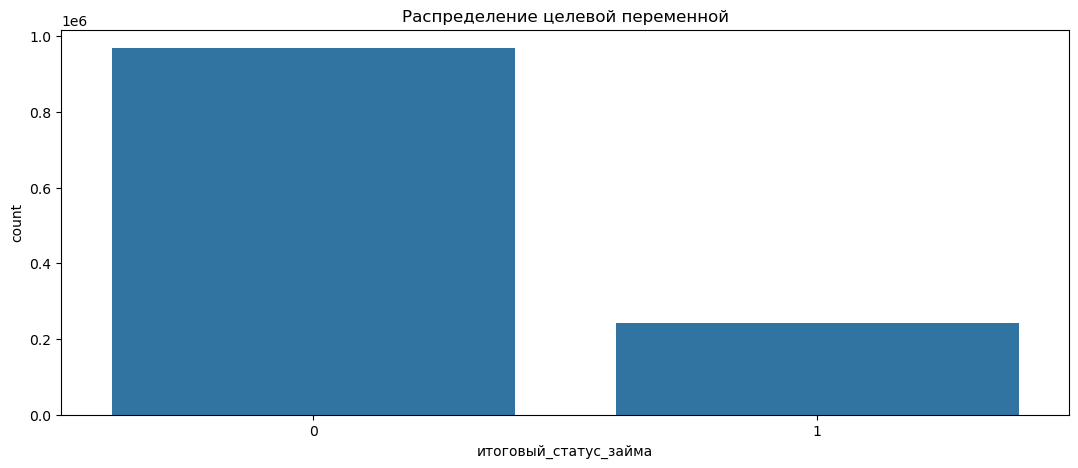

In [6]:
plt.figure(figsize=(13,5));
sns.countplot(data=df_train, x='–∏—Ç–æ–≥–æ–≤—ã–π_—Å—Ç–∞—Ç—É—Å_–∑–∞–π–º–∞');
plt.title(f"–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π")
plt.show()

–Ø–≤–Ω—ã–π –¥–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤

In [7]:
def reprez_sample(
    df: pd.DataFrame | pd.Series,
    y: pd.Series = None,
    frac: list | np.ndarray = None,
    random_state: int | float = RANDOM_STATE,
    alpha: float = 0.05
):

    if isinstance(df, pd.DataFrame) and y is None and isinstance(frac, (list, np.ndarray)):
        for f in frac:
            y_sample = df.sample(frac=f, random_state=random_state)
            all_similar = True

            for col in df.columns:
                try:
                    series_full = df[col].dropna()
                    series_sample = y_sample[col].dropna()

                    # –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
                    if series_full.dtype == 'object' or series_full.dtype.name == 'category':
                        
                        full_freq = series_full.value_counts(normalize=True)
                        sample_freq = series_sample.value_counts(normalize=True)

                        categories = full_freq.index.union(sample_freq.index)
                        full_freq = full_freq.reindex(categories, fill_value=0)
                        sample_freq = sample_freq.reindex(categories, fill_value=0)

                        _, p_value = chisquare(f_obs=sample_freq, f_exp=full_freq)
                        test_type = "Chi**2"

                    # –ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
                    else:
                        _, p_value = ks_2samp(series_full, series_sample)
                        test_type = "KS"

                    if p_value < alpha:
                        print(f'[{test_type}] {col} ‚Äî p={p_value:.3f}, –≤—ã–±–æ—Ä–∫–∏ —Ä–∞–∑–ª–∏—á–Ω—ã.')
                        all_similar = False
                        break

                except Exception as e:
                    print(f'–û—à–∏–±–∫–∞ –ø—Ä–∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏–∏ "{col}": {e}')
                    all_similar = False
                    break

            if all_similar:
                print(f'–í—Å–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å–æ–≤–ø–∞–¥–∞—é—Ç –ø—Ä–∏ f = {f:.0%}')
                return f

        print('–ù–µ —É–¥–∞–ª–æ—Å—å –Ω–∞–π—Ç–∏ —Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω—ã–π –ø—Ä–æ—Ü–µ–Ω—Ç –≤—ã–±–æ—Ä–∫–∏.')
        return None

    elif y is not None:
    # –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –¥–≤—É—Ö Series
        x = df.dropna()
        y = y.dropna()

        if x.dtype == 'object' or x.dtype.name == 'category':
            full_freq = x.value_counts(normalize=True)
            sample_freq = y.value_counts(normalize=True)
            categories = full_freq.index.union(sample_freq.index)
            full_freq = full_freq.reindex(categories, fill_value=0)
            sample_freq = sample_freq.reindex(categories, fill_value=0)

            _, p_value = chisquare(f_obs=sample_freq, f_exp=full_freq)
            test_type = "Chi**2"
        else:
            _, p_value = ks_2samp(x, y)
            test_type = "KS"

        if p_value < alpha:
            print(f'[{test_type}] –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–∞–∑–ª–∏—á–Ω—ã (p={p_value:.3f})')
        else:
            print(f'[{test_type}] –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å–æ–≤–ø–∞–¥–∞—é—Ç (p={p_value:.3f})')

        return p_value

    else:
        raise ValueError("–ù–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã–π —Ñ–æ—Ä–º–∞—Ç –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö.")

In [8]:
#sample_ks_2sample(df_train['TotalCharges'], df_test['TotalCharges'])
#sample_ks_2sample(df_train.drop(columns='id'), df_test.drop(columns='id'))

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –Ω–∞ –æ–¥–Ω–æ—Ä–æ–¥–Ω–æ—Å—Ç—å –¥–≤—É—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ª–∏–±–æ –¥–∞—Ç–∞—Å–µ—Ç–æ–≤

–û—Ç–ª–∏—á–Ω—ã–π –≤–æ–ø—Ä–æ—Å. –¢—ã –º–æ–∂–µ—à—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω—É—é –ø–æ–¥–≤—ã–±–æ—Ä–∫—É –¥–ª—è –æ–±—É—á–µ–Ω–∏—è, –Ω–æ –µ—Å—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ –∫–ª—é—á–µ–≤—ã—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –Ω—É–∂–Ω–æ —É—á–∏—Ç—ã–≤–∞—Ç—å. –í–æ—Ç –ø–æ–¥—Ä–æ–±–Ω—ã–π —Ä–∞–∑–±–æ—Ä:

‚úÖ –ö–æ–≥–¥–∞ –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø–æ–¥–≤—ã–±–æ—Ä–∫—É (–Ω–∞–ø—Ä–∏–º–µ—Ä, 120 —Ç—ã—Å. –∏–∑ 1.2 –º–ª–Ω)
üîπ 1. –ï—Å–ª–∏ –¥–∞–Ω–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –∏–∑–±—ã—Ç–æ—á–Ω—ã
–ï—Å–ª–∏ –º–æ–¥–µ–ª—å –Ω–µ –≤—ã–∏–≥—Ä—ã–≤–∞–µ—Ç –æ—Ç –±–æ–ª—å—à–æ–≥–æ –æ–±—ä—ë–º–∞ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –ø—Ä–æ—Å—Ç—ã–µ –º–æ–¥–µ–ª–∏: –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è, –¥–µ—Ä–µ–≤–æ —Ä–µ—à–µ–Ω–∏–π).

–ï—Å–ª–∏ –∫–∞—á–µ—Å—Ç–≤–æ –Ω–µ —É—Ö—É–¥—à–∞–µ—Ç—Å—è –ø—Ä–∏ —É–º–µ–Ω—å—à–µ–Ω–∏–∏ –æ–±—ä—ë–º–∞ (—Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω–æ—Å—Ç—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞, —á—Ç–æ —Ç—ã –∏ –ø—Ä–æ–≤–µ—Ä–∏–ª —á–µ—Ä–µ–∑ ks_2samp).

–û—Å–æ–±–µ–Ω–Ω–æ –ø–æ–ª–µ–∑–Ω–æ –Ω–∞ —ç—Ç–∞–ø–µ –ø—Ä–æ—Ç–æ—Ç–∏–ø–∏—Ä–æ–≤–∞–Ω–∏—è ‚Äî –±—ã—Å—Ç—Ä–µ–µ –∑–∞–ø—É—Å–∫–∞—Ç—å —Ü–∏–∫–ª—ã –æ–±—É—á–µ–Ω–∏—è –∏ –ø–æ–¥–±–æ—Ä–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.

üîπ 2. –ï—Å–ª–∏ —Ä–µ—Å—É—Ä—Å—ã –æ–≥—Ä–∞–Ω–∏—á–µ–Ω—ã
–û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è –ø–æ –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ–π –ø–∞–º—è—Ç–∏ (RAM), GPU/CPU –∏–ª–∏ –≤—Ä–µ–º–µ–Ω–∏ –æ–±—É—á–µ–Ω–∏—è ‚Äî –æ—Å–æ–±–µ–Ω–Ω–æ –∞–∫—Ç—É–∞–ª—å–Ω–æ –¥–ª—è –±–æ–ª—å—à–∏—Ö –º–æ–¥–µ–ª–µ–π.

–î–∞–∂–µ 10% –æ—Ç –±–æ–ª—å—à–∏—Ö –¥–∞–Ω–Ω—ã—Ö –º–æ–∂–µ—Ç –±—ã—Ç—å –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –¥–ª—è –¥–æ—Å—Ç–∏–∂–µ–Ω–∏—è ~90% –æ—Ç –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞.

üîπ 3. –î–ª—è –±–∞–∑–æ–≤–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –∏–ª–∏ AutoML
–ë—ã—Å—Ç—Ä–µ–µ –æ–±—É—á–∞—Ç—å baseline-–º–æ–¥–µ–ª—å, –∏—Å–∫–∞—Ç—å –≤–∞–∂–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏, –æ—Ç—Å–µ–∏–≤–∞—Ç—å –Ω–µ–Ω—É–∂–Ω—ã–µ.

–ë—ã—Å—Ç—Ä–µ–µ –ø—Ä–æ–≤–æ–¥–∏—Ç—å –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—é –∏ grid search.

‚ö†Ô∏è –ö–æ–≥–¥–∞ –ª—É—á—à–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –≤—Å—é –≤—ã–±–æ—Ä–∫—É
üî∏ 1. –§–∏–Ω–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ –ø–µ—Ä–µ–¥ –ø—Ä–æ–¥–∞–∫—à–µ–Ω–æ–º
–ü–æ—Å–ª–µ —Ç–æ–≥–æ –∫–∞–∫ —Ç—ã –Ω–∞—Å—Ç—Ä–æ–∏–ª –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∏ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É ‚Äî –ª—É—á—à–µ –æ–±—É—á–∞—Ç—å –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö, —á—Ç–æ–±—ã –ø–æ–ª—É—á–∏—Ç—å –º–∞–∫—Å–∏–º—É–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –∏ —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç—å.

üî∏ 2. –ï—Å–ª–∏ –º–æ–¥–µ–ª—å —Å–ª–æ–∂–Ω–∞—è (–Ω–µ–π—Ä–æ—Å–µ—Ç–∏, –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–π –±—É—Å—Ç–∏–Ω–≥)
–¢–∞–∫–∏–µ –º–æ–¥–µ–ª–∏ –≤—ã–∏–≥—Ä—ã–≤–∞—é—Ç –æ—Ç –±–æ–ª—å—à–∏—Ö –æ–±—ä—ë–º–æ–≤ –¥–∞–Ω–Ω—ã—Ö ‚Äî –¥–∞–∂–µ –µ—Å–ª–∏ —Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω–æ—Å—Ç—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞, –±–æ–ª—å—à–µ –¥–∞–Ω–Ω—ã—Ö = –ª—É—á—à–µ –æ–±–æ–±—â–µ–Ω–∏–µ.

üî∏ 3. –ö–æ–≥–¥–∞ –¥–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤
–ï—Å–ª–∏ –∑–∞–¥–∞—á–∞ –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–∞, —É–º–µ–Ω—å—à–µ–Ω–∏–µ –≤—ã–±–æ—Ä–∫–∏ –º–æ–∂–µ—Ç —É–¥–∞–ª–∏—Ç—å –≤–∞–∂–Ω—ã–µ —Ä–µ–¥–∫–∏–µ —Å–ª—É—á–∞–∏.

üìå –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏
–¶–µ–ª—å	–ò—Å–ø–æ–ª—å–∑—É–π –ø–æ–¥–≤—ã–±–æ—Ä–∫—É?	–û–±—ä—ë–º
–ò—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ, –∞–Ω–∞–ª–∏–∑	‚úÖ	5‚Äì20%
–ü–æ–¥–±–æ—Ä –º–æ–¥–µ–ª–∏ / GridSearch	‚úÖ	10‚Äì30%
–§–∏–Ω–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ	‚ùå	100%
–û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è –ø–æ –ø–∞–º—è—Ç–∏	‚úÖ	–º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ –≤–æ–∑–º–æ–∂–Ω—ã–π –±–µ–∑ –ø–æ—Ç–µ—Ä—å

üí° –í—ã–≤–æ–¥
‚û°Ô∏è –î–∞, —Ç—ã –º–æ–∂–µ—à—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø–æ–¥–≤—ã–±–æ—Ä–∫—É, –µ—Å–ª–∏ –æ–Ω–∞ —Ä–µ–ø—Ä–µ–∑–µ–Ω—Ç–∞—Ç–∏–≤–Ω–∞ (–∏ —Ç—ã —ç—Ç–æ —É–∂–µ –ø—Ä–æ–≤–µ—Ä–∏–ª).
–î–ª—è –Ω–∞—á–∞–ª—å–Ω—ã—Ö —ç—Ç–∞–ø–æ–≤, –∞–Ω–∞–ª–∏–∑–∞ –∏ –æ—Ç–ª–∞–¥–∫–∏ ‚Äî —ç—Ç–æ –¥–∞–∂–µ —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è.
–ù–æ –¥–ª—è –ø—Ä–æ–¥–∞–∫—à–µ–Ω-–º–æ–¥–µ–ª–∏ —Å—Ç–æ–∏—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –≤—Å—é –æ–±—É—á–∞—é—â—É—é –≤—ã–±–æ—Ä–∫—É, –µ—Å–ª–∏ –ø–æ–∑–≤–æ–ª—è—é—Ç —Ä–µ—Å—É—Ä—Å—ã.

–•–æ—á–µ—à—å ‚Äî –º–æ–≥—É –ø–æ–º–æ—á—å –ø–æ—Å—Ç—Ä–æ–∏—Ç—å –ø–∞–π–ø–ª–∞–π–Ω, –≥–¥–µ –±—É–¥–µ—Ç –æ–±—É—á–µ–Ω–∏–µ –Ω–∞ –ø–æ–¥–≤—ã–±–æ—Ä–∫–µ + —Ñ–∏–Ω–∞–ª—å–Ω–æ–µ –¥–æ–æ–±—É—á–µ–Ω–∏–µ –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö.

In [9]:
fracs = [0.1,0.2, 0.3, 0.5, 0.7]  # —Å–ø–∏—Å–æ–∫ –¥–æ–ª–µ–π –ø–æ–¥–≤—ã–±–æ—Ä–∫–∏
#frac_range = np.linspace(0.1, 0.9, 9)
best_frac = reprez_sample(df_train.drop(columns=['id']), frac=fracs)

–í—Å–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å–æ–≤–ø–∞–¥–∞—é—Ç –ø—Ä–∏ f = 10%


In [10]:
df_train_EDA = df_train.sample(frac=best_frac,random_state=RANDOM_STATE)

In [11]:
cat_like_num = []

for i in df_train_EDA.columns[1:]:
    if (df_train_EDA[i].dtype == int or df_train_EDA[i].dtype == float) and df_train_EDA[i].nunique()  <= 30:
        cat_like_num.append(i)

In [12]:
NUM_COLS = df_train_EDA.select_dtypes(include=['number']).columns
NUM_COLS = [i for i in NUM_COLS if i not in cat_like_num][1:]

CAT_COLS = list(df_train_EDA.select_dtypes(include=['object', 'category', 'bool']).columns) + cat_like_num

In [13]:
CAT_COLS

['—Å—Ä–æ–∫_–∑–∞–π–º–∞',
 '—Ä–µ–π—Ç–∏–Ω–≥',
 '–¥–æ–ø—Ä–µ–π—Ç–∏–Ω–≥',
 '–ø—Ä–æ—Ñ–µ—Å—Å–∏—è_–∑–∞–µ–º—â–∏–∫–∞',
 '—Å—Ç–∞–∂',
 '–≤–ª–∞–¥–µ–Ω–∏–µ_–∂–∏–ª—å–µ–º',
 '–ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω_–ª–∏_–¥–æ—Ö–æ–¥',
 '–ø–ª–∞—Ç–µ–∂–Ω—ã–π_–≥—Ä–∞—Ñ–∏–∫',
 '—Ü–µ–ª—å_–∑–∞–π–º–∞',
 '—Ä–µ–≥–∏–æ–Ω',
 '–ø–æ—Å_—Å—Ç–æ–ø_—Ñ–∞–∫—Ç–æ—Ä',
 '—é—Ä–∏–¥–∏—á–µ—Å–∫–∏–π_—Å—Ç–∞—Ç—É—Å',
 '–¥–∞—Ç–∞_–ø–µ—Ä–≤–æ–≥–æ_–∑–∞–π–º–∞',
 '–ø–µ—Ä–≤–æ–Ω–∞—á–∞–ª—å–Ω—ã–π_—Å—Ç–∞—Ç—É—Å_–∑–∞–π–º–∞',
 '–ø–µ–Ω–∏_–∑–∞_–¥–µ—Ñ–æ–ª—Ç',
 '—Ç–∏–ø_–∑–∞–π–º–∞',
 '—Å–æ–≤–æ–∫—É–ø–Ω—ã–π_—Å—Ç–∞—Ç—É—Å_–ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω–∏—è_–¥–æ—Ö–æ–¥–æ–≤_–∑–∞–µ–º—â–∏–∫–æ–≤',
 '–æ—Å–æ–±–∞—è_—Å–∏—Ç—É–∞—Ü–∏—è',
 '—Ç–∏–ø_–ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è_–∫—Ä–µ–¥–∏—Ç–∞',
 '–∏—Ç–æ–≥–æ–≤—ã–π_—Å—Ç–∞—Ç—É—Å_–∑–∞–π–º–∞',
 '—Ä–µ–π—Ç–∏–Ω–≥_OCR',
 '–∫–æ–ª_–≤–æ_—Å—É–±—Å–∏–¥–∏–π_–∑–∞_–≥–æ–¥',
 '–∫–æ–ª-–≤–æ_–ø—Ä–æ—Å—Ä–æ—á–µ–∫_–∑–∞_–¥–≤–∞_–≥–æ–¥–∞',
 '–∫–æ—ç—Ñ—Ñ_–Ω–µ–≤—ã–ø–ª–∞—á–µ–Ω–Ω–æ–≥–æ_—Å—É–º–º_–æ—Å—Ç–∞—Ç–∫–∞',
 '–∫–æ–ª-–≤–æ_–∑–∞—è–≤–æ–∫_–∑–∞_–ø–æ–ª–≥–æ–¥–∞',
 '–∫–æ–ª-–≤–æ_–∑–∞–ø–∏—Å–µ–π_

In [14]:
def  outlier_ratio(srs: pd.Series):
    q1 = srs.quantile(0.25)
    q3 = srs.quantile(0.75)
    iqr = q3 - q1
    left = q1 - iqr * 1.5
    right = q3 + iqr * 1.5

    ratio = (srs[srs < left].count() + srs[srs > right].count()) / len(srs)
    return ratio

In [16]:
def EDA_for_num(df: pd.DataFrame, num_cols: list):
    n = len(num_cols)
    cols = 5
    rows = int(np.ceil(n / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axs = axs.flatten()

    for i, col in enumerate(num_cols):
        ax = axs[i]
        df[col].hist(bins='auto', ax=ax)
        outlier_perc = outlier_ratio(df[col])
        ax.set_title(f'–ü—Ä–∏–∑–Ω–∞–∫ "{col}"\n–í—ã–±—Ä–æ—Å–æ–≤: {outlier_perc:.1%}', fontsize=9)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã 10 –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

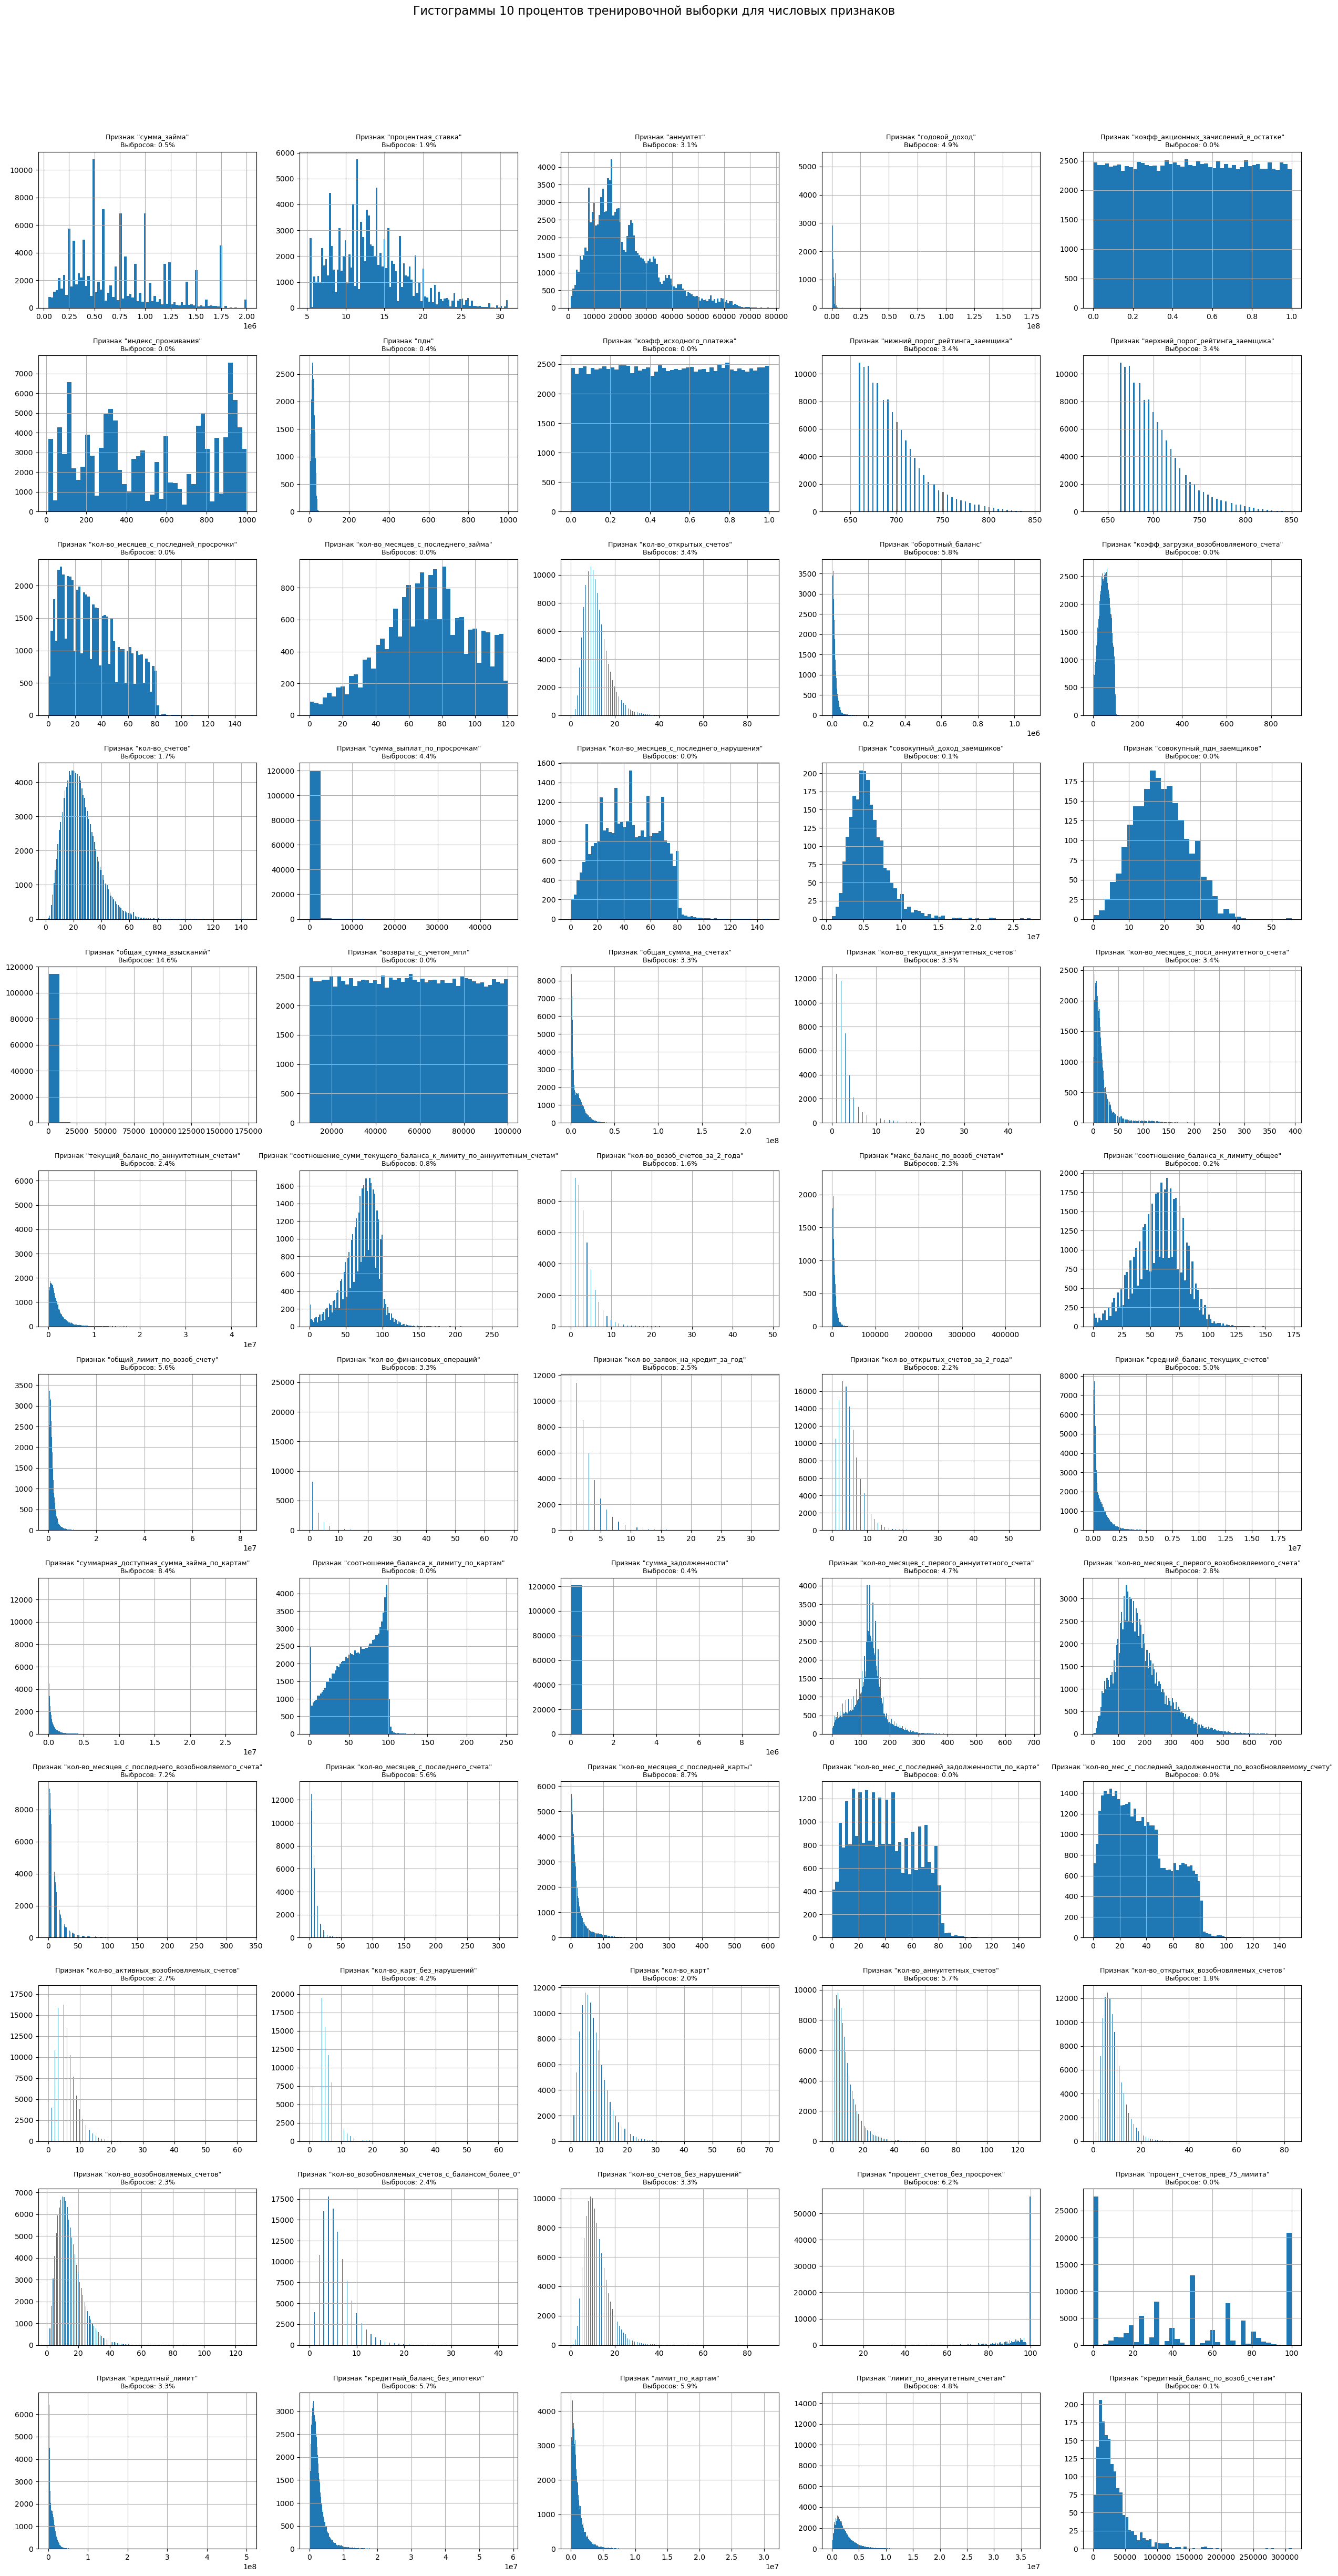

In [17]:
EDA_for_num(df_train_EDA,NUM_COLS)

In [19]:
def EDA_for_cat(df: pd.DataFrame, cat_cols: list):
    n = len(cat_cols)
    cols = 5
    rows = int(np.ceil(n / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axs = axs.flatten()

    for i, col in enumerate(cat_cols):
        ax = axs[i]
        sns.countplot(data=df, hue='–∏—Ç–æ–≥–æ–≤—ã–π_—Å—Ç–∞—Ç—É—Å_–∑–∞–π–º–∞',x=col, order=df[col].value_counts().index, ax=ax)

    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('–°—Ç–æ–ª–±—á–∞—Ç—ã–µ –¥–∏–∞–≥—Ä–∞–º–º—ã 10 –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤', fontsize=16, y=1.02)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

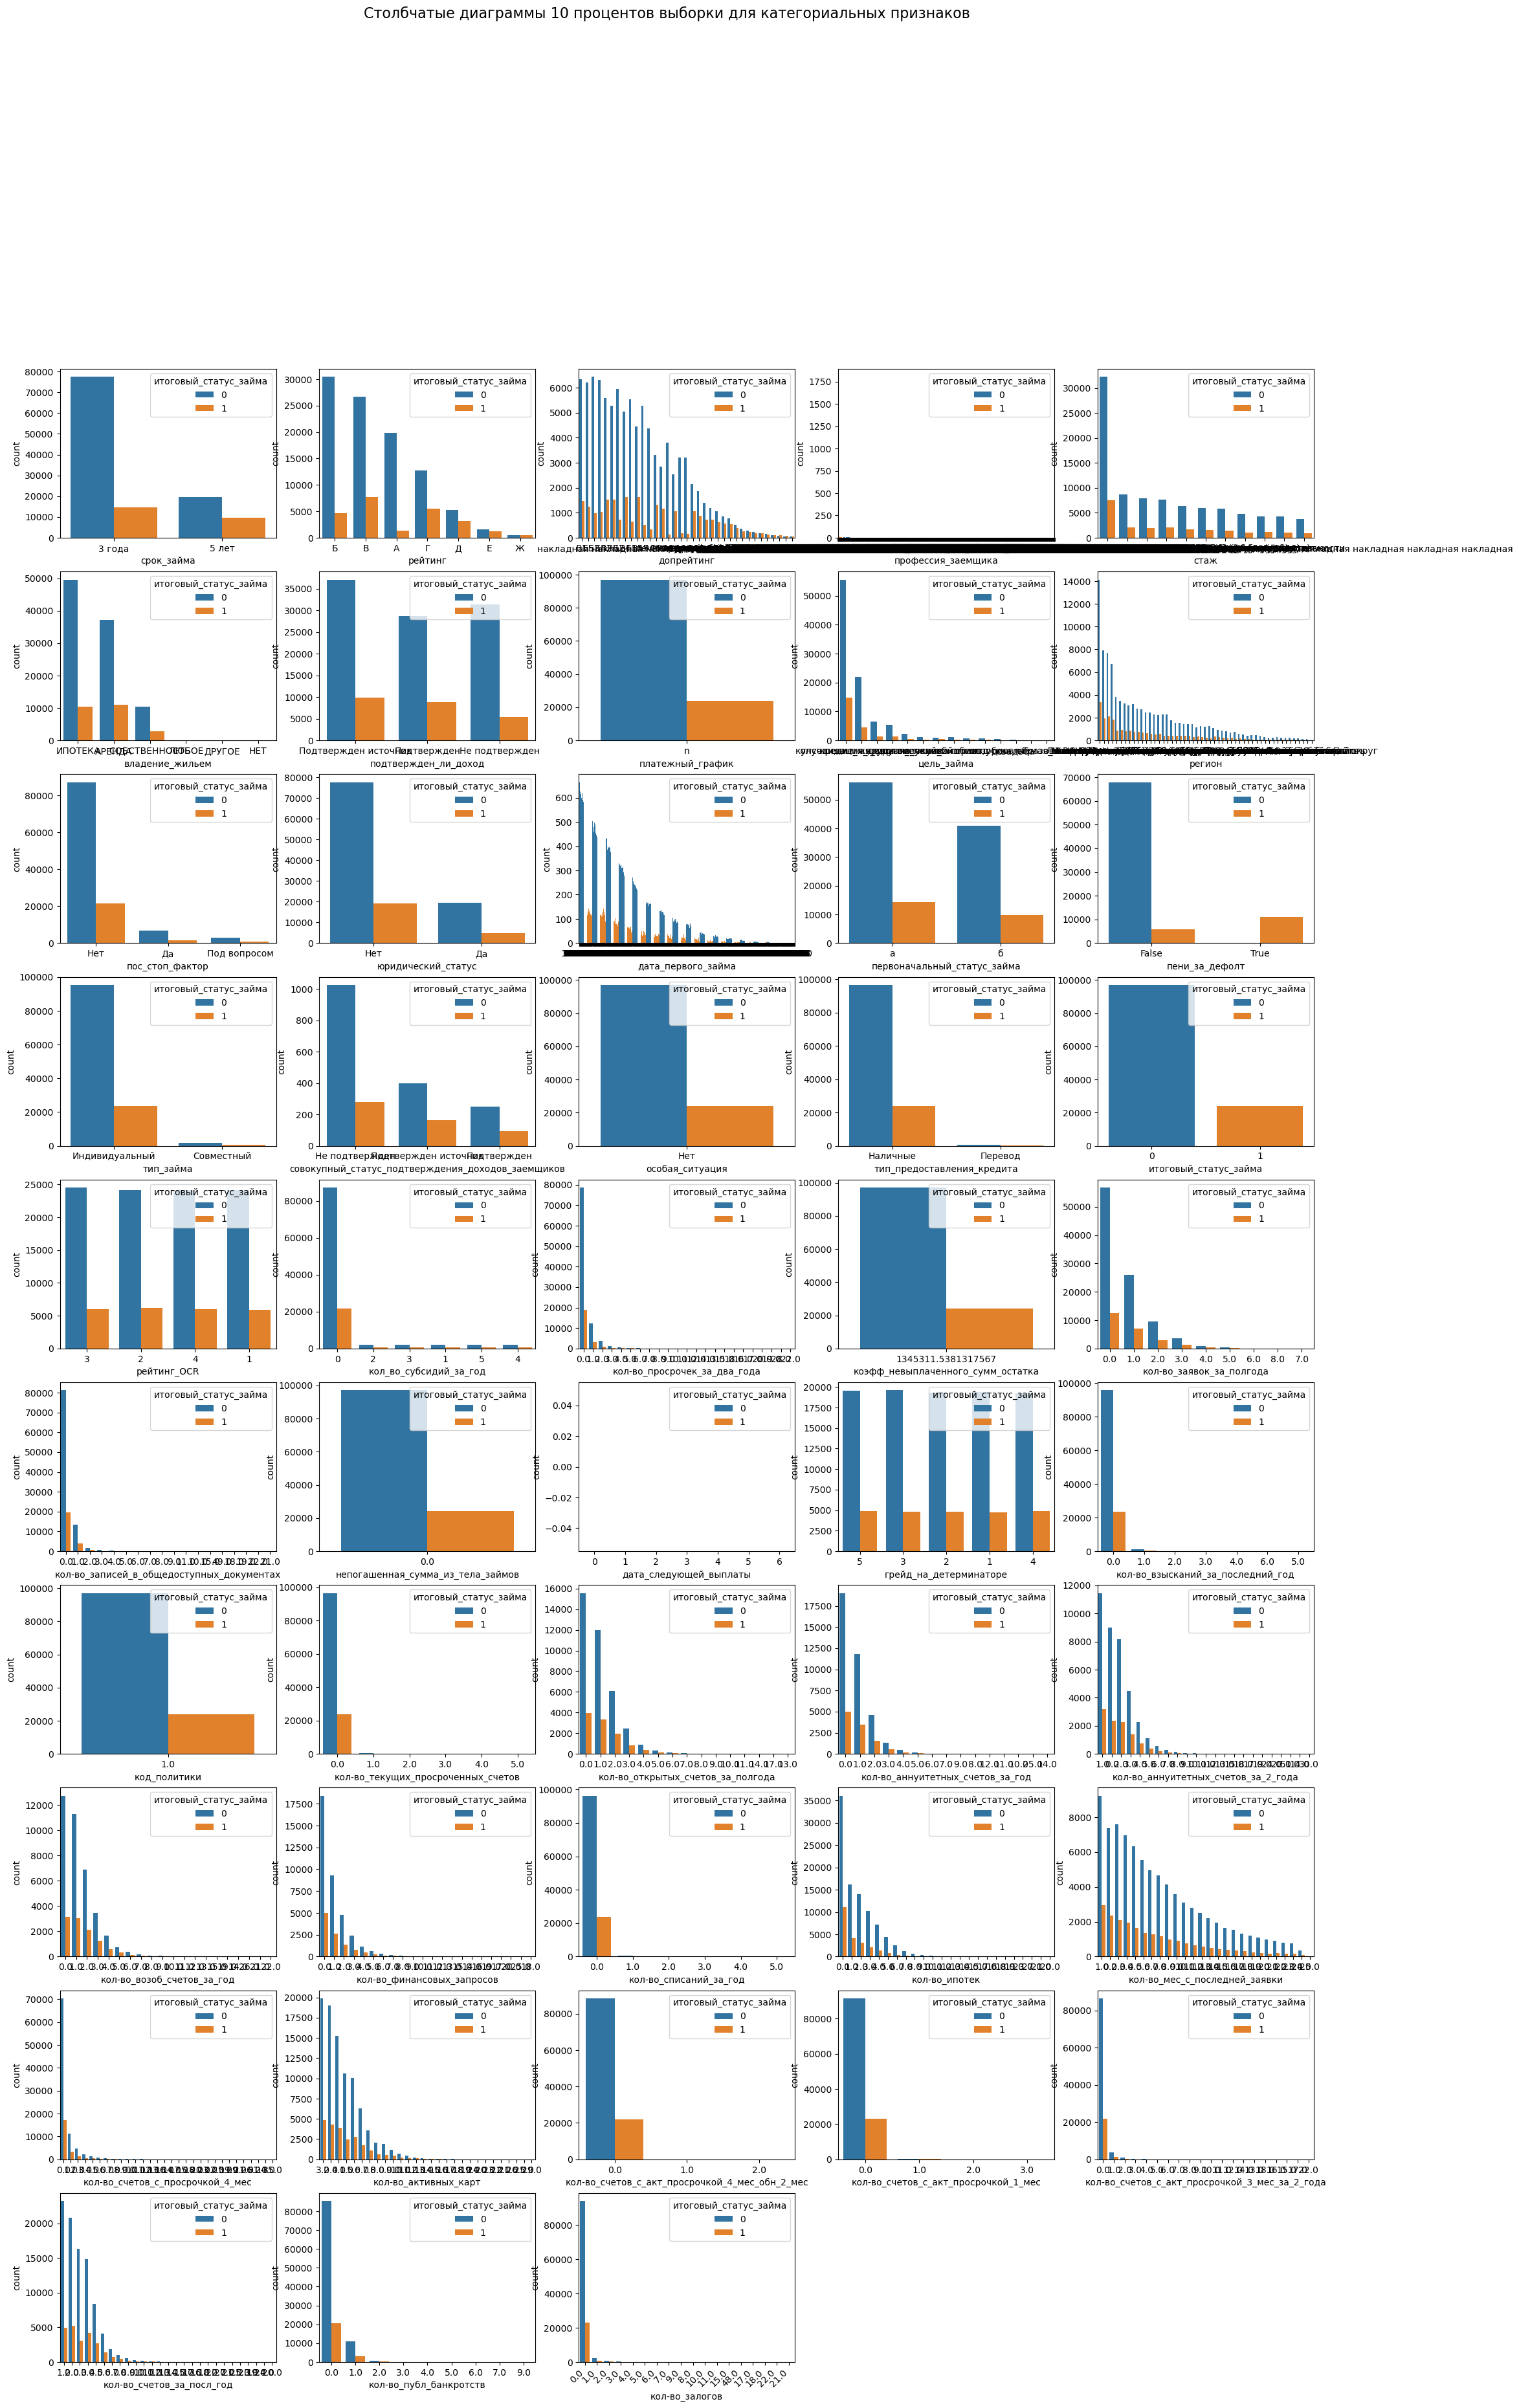

In [20]:
EDA_for_cat(df_train_EDA,CAT_COLS)



phik_corr_train = df_train.drop(['id'],axis=1).phik_matrix(interval_cols=lst)

plt.figure(figsize=(15, 8))
sns.heatmap(phik_corr_train, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

def get_eda_plots(
    df: pd.DataFrame,
    name=None,
    sample_frac=None,
    seed=RANDOM_STATE,
    outliers=True,
    max_cat_unique=20
):
    # –°—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏–µ
    if sample_frac:
        df_to_plot = df.sample(frac=sample_frac, random_state=seed)
        sample_t = f' {sample_frac:.0%} –≤—ã–±–æ—Ä–∫–∏'
    else:
        df_to_plot = df
        sample_t = ''

    name = f' –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ "{name}"' if name else ''

    # –û–ø—Ä–µ–¥–µ–ª–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∏
    num_cols = df_to_plot.select_dtypes(include=['number']).columns
    cat_cols = [col for col in df_to_plot.columns 
                if df_to_plot[col].dtype == 'object' or
                   df_to_plot[col].dtype.name == 'category' or
                   df_to_plot[col].nunique() <= max_cat_unique]

    # === –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ===
    if not num_cols.empty:
        n = len(num_cols)
        cols = 5
        rows = int(np.ceil(n / cols))

        fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        axs = axs.flatten()

        for i, col in enumerate(num_cols):
            ax = axs[i]
            df_to_plot[col].hist(bins=50, ax=ax)
            if outliers:
                outlier_perc = outlier_ratio(df[col])  # –í–Ω–µ—à–Ω—è—è —Ñ—É–Ω–∫—Ü–∏—è!
                ax.set_title(f'–ü—Ä–∏–∑–Ω–∞–∫ "{col}"\n–í—ã–±—Ä–æ—Å–æ–≤: {outlier_perc:.1%}', fontsize=9)
            else:
                ax.set_title(f'–ü—Ä–∏–∑–Ω–∞–∫ "{col}"', fontsize=9)

        for j in range(n, len(axs)):
            fig.delaxes(axs[j])

        fig.suptitle('–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã' + sample_t + name, fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

    # === –°—Ç–æ–ª–±—á–∞—Ç—ã–µ –≥—Ä–∞—Ñ–∏–∫–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ ===
    if cat_cols:
        n = len(cat_cols)
        cols = 3
        rows = int(np.ceil(n / cols))

        fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
        axs = axs.flatten()

        for i, col in enumerate(cat_cols):
            ax = axs[i]
            sns.countplot(data=df_to_plot, x=col, order=df_to_plot[col].value_counts().index, ax=ax)
            ax.set_title(f'–ü—Ä–∏–∑–Ω–∞–∫ "{col}"', fontsize=10)
            ax.tick_params(axis='x', rotation=45)

        for j in range(n, len(axs)):
            fig.delaxes(axs[j])

        fig.suptitle('–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏' + sample_t + name, fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

    # === –î–∏–∞–≥—Ä–∞–º–º—ã —Ä–∞–∑–º–∞—Ö–∞ ===
    if not num_cols.empty:
        plt.figure(figsize=(20, 8))
        df_to_plot[num_cols].plot(kind='box', grid=True)
        plt.title('–î–∏–∞–≥—Ä–∞–º–º—ã —Ä–∞–∑–º–∞—Ö–∞' + sample_t + name + '.', fontsize=16)
        plt.tight_layout()
        plt.show()